# ULMFiT + Siamese Network for Sentence Vectors
## Part Two: Pretraining
This notebook will build a language model from Lernapparat (https://lernapparat.de/german-lm/) retrain it on the Office FAQ dataset. 


In [1]:
# Needed to load fastai library
import sys
sys.path.append("/data/home/makayser/notebooks/fastai/") # go to parent dir

In [3]:
from fastai.text import *
# from fastai.torch_core import *
# from fastai.core import *
# import fastai.metrics as metrics

# added to account for missing in newest fastai version
#from old.fastai import core as old_core
#from old.fastai import text as old_text

import json
import html
import re
import pickle
from collections import Counter
import random
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn
from sklearn import model_selection
from functools import partial
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.utils 
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import dataset, dataloader
import torch.optim as optim
import torch.nn.functional as F

import time
import math
import sys
#import data

data_dir = '/data/home/makayser/qa_local/'
token_files = data_dir + 'token/'

PATH = Path(data_dir)
%load_ext autoreload
%autoreload 2

## Load the tokens from the OFFICE-DE data

In [4]:
itos = pickle.load(open(f'{token_files}itos.pkl', 'rb'))
trn_lm = np.load(f'{token_files}trn_lm.npy')
val_lm = np.load(f'{token_files}val_lm.npy')

stoi = defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
vocab_size = len(itos)
vocab_size

41012

In [5]:
# check to make sure that the data looks ok
for word in trn_lm[:100]:
    print(itos[word], end=" ")

x_bos drucken eines dokuments in word x_bos anzeigen oder ändern der eigenschaften für eine office-datei x_bos ändern der hintergrundfarbe in word 2016 für mac x_bos erforderliche komponenten : office   365 abonnement , exchange online planin diesem artikel wird erläutert , wie sie e-mails von geräten und geschäftsanwendungen senden können , wenn sich alle ihre postfächer in office   365 befinden . beispiel : sie verfügen über einen scanner und möchten gescannte dokumente per e-mail an sich selbst oder eine andere person senden.sie verfügen über eine xxup lob-anwendung ( branchenanwendung ) , die termine verwaltet , und sie möchten terminerinnerungen 

## Load the Wikitext LM and fix the weights

In [6]:
#download the wikitext LM (NOTE: this is for english..)
# ! wget -nH -r -np -P ./data/aclImdb/ http://files.fast.ai/models/wt103/

#German version:
#https://lernapparat.de/german-lm/

In [7]:
#these are the values used for the original LM
em_sz,nh,nl = 300,1150,3
PRE_PATH = PATH/'model'/'wikide80k'
PRE_LM_PATH = PRE_PATH/'fwd_wikide_80k.h5'
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [9]:
#get the mean weight value for any new vocab
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load(Path(PRE_PATH/'itos.pkl').open('rb'))
stoi2 = defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

#fill in the missing values from the old vocab
new_w = np.zeros((vocab_size, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m
    
#fix up the wgts with the new values
wgts['0.encoder.weight'] = T(new_w) #old_core.
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w)) #old_core.
wgts['1.decoder.weight'] = T(np.copy(new_w)) #old_

In [12]:
max_seq = 20*70
wd = 1e-7
bptt = 70
batch_size = 32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

trn_dl = LanguageModelLoader(trn_lm, batch_size, bptt) #old_text.
val_dl = LanguageModelLoader(val_lm, batch_size, bptt) #old_text.
md = LanguageModelData(PATH, 1, vocab_size, trn_dl, val_dl, bs=batch_size, bptt=bptt) #old_text.

### Create the language model and load the weigths

In [17]:
torch.cuda.empty_cache()

In [18]:
torch.cuda.get_device_properties(0) #torch.cuda.device(0get_device_properties

_CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)

In [19]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

learner.model.load_state_dict(wgts)

#### Determine Learning Rate

In [20]:
%%time

lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1) #32

epoch      trn_loss   val_loss   accuracy                     
    0      4.895065   4.860074   0.223102  

CPU times: user 5min 11s, sys: 1min 53s, total: 7min 4s
Wall time: 7min 4s


In [21]:
learner.unfreeze()

In [22]:
%%time

learner.lr_find(start_lr=lrs/20, end_lr=lrs*20, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      3.928822   3.876736   0.32142   

CPU times: user 6min 6s, sys: 2min 7s, total: 8min 13s
Wall time: 8min 15s


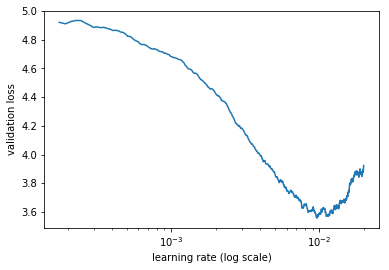

In [23]:
learner.sched.plot()

#### Select LR, Train model

In [24]:
%%time 

lrs=1e-2
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=20)

epoch      trn_loss   val_loss   accuracy                     
    0      3.060892   2.935077   0.459551  
    1      3.125398   2.972379   0.447151                     
    2      3.077123   2.940768   0.451255                     
    3      2.968874   2.850222   0.467627                     
    4      2.843171   2.762165   0.481978                     
    5      2.759367   2.677004   0.496307                     
    6      2.64169    2.605597   0.510705                     
    7      2.547499   2.53336    0.524249                     
    8      2.483468   2.466642   0.535937                     
    9      2.403238   2.411269   0.547418                     
    10     2.290747   2.35362    0.558223                     
    11     2.24485    2.30859    0.568137                     
    12     2.216932   2.25755    0.577254                     
 72%|███████▏  | 820/1138 [05:42<02:14,  2.36it/s, loss=2.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    17     1.853851   2.102079   0.611491                     
    18     1.849971   2.080473   0.615579                     
 68%|██████▊   | 779/1138 [05:24<02:10,  2.75it/s, loss=1.78]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
torch.save(learner.model, "oa_language_model_lr001_e20_v2.pt")

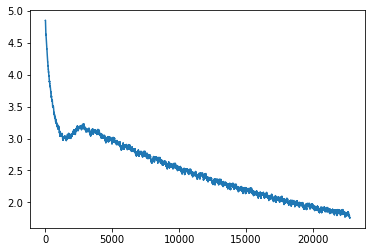

In [26]:
learner.sched.plot_loss()

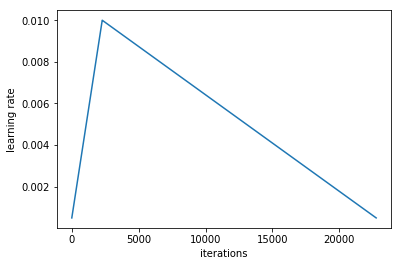

In [27]:
learner.sched.plot_lr()